In [32]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

Unzipping files...
unzip:  cannot find or open /content/training1.zip, /content/training1.zip.zip or /content/training1.zip.ZIP.
unzip:  cannot find or open /content/training2.zip, /content/training2.zip.zip or /content/training2.zip.ZIP.
unzip:  cannot find or open /content/test.zip, /content/test.zip.zip or /content/test.zip.ZIP.
unzip:  cannot find or open /content/test_partial.zip, /content/test_partial.zip.zip or /content/test_partial.zip.ZIP.
Merging training data...
mkdir: cannot create directory ‘/content/training’: File exists
mv: cannot move '/content/training1/00000' to '/content/training/00000': Directory not empty
mv: cannot move '/content/training1/00001' to '/content/training/00001': Directory not empty
mv: cannot move '/content/training1/00002' to '/content/training/00002': Directory not empty
mv: cannot move '/content/training1/00003' to '/content/training/00003': Directory not empty
mv: cannot move '/content/training1/00004' to '/content/training/00004': Directory not

In [30]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [37]:
training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validation sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and augmentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=.2
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=.2
)

# Define class weights
class_weights = {0: 1.0, 1: 2.0, 2: 1.5}

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    subset="training",
    batch_size=32,
    class_mode='sparse',
    seed=42,
    shuffle=True,
)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="validation",
    seed=42,
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


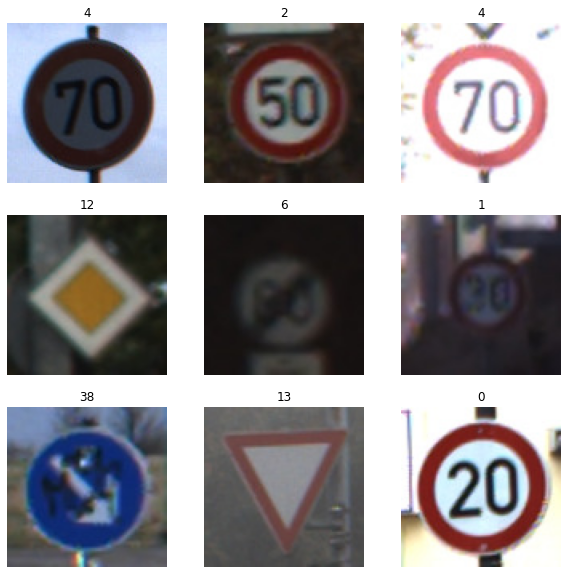

In [38]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]      
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [43]:
# Build a model...

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation='softmax'))  # changed output shape to 1

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # changed loss function to 'sparse_categorical_crossentropy'

class_counts = {}
for c in train_generator.classes:
    if c not in class_counts:
        class_counts[c] = 0
    class_counts[c] += 1

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # changed loss function to 'sparse_categorical_crossentropy'

# Define a new generator class that includes class weights
class WeightedGenerator(keras.utils.Sequence):
    def __init__(self, generator, class_weights):
        self.generator = generator
        self.class_weights = class_weights
        
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, index):
        batch_x, batch_y = self.generator[index]
        batch_weight = np.array([self.class_weights[y] for y in batch_y])
        return (batch_x, batch_y, batch_weight)
        
# Create new generators with the weighted generator class
train_weighted_generator = WeightedGenerator(train_generator, class_weights)
validation_weighted_generator = WeightedGenerator(validation_generator, class_weights)

# Fit the model with the training data
history = model.fit(
    train_weighted_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_weighted_generator,
    validation_steps=50
)


Epoch 1/10
100/100 [==============================] - 6s 52ms/step - loss: 0.0412 - accuracy: 0.1466 - val_loss: 0.0343 - val_accuracy: 0.2744
Epoch 2/10
100/100 [==============================] - 6s 58ms/step - loss: 0.0235 - accuracy: 0.4634 - val_loss: 0.0242 - val_accuracy: 0.5119
Epoch 3/10
100/100 [==============================] - 4s 37ms/step - loss: 0.0135 - accuracy: 0.6581 - val_loss: 0.0195 - val_accuracy: 0.5956
Epoch 4/10
100/100 [==============================] - 5s 46ms/step - loss: 0.0088 - accuracy: 0.7731 - val_loss: 0.0198 - val_accuracy: 0.6194
Epoch 5/10
100/100 [==============================] - 4s 37ms/step - loss: 0.0066 - accuracy: 0.8221 - val_loss: 0.0169 - val_accuracy: 0.7225
Epoch 6/10
100/100 [==============================] - 4s 37ms/step - loss: 0.0045 - accuracy: 0.8681 - val_loss: 0.0186 - val_accuracy: 0.7200
Epoch 7/10
100/100 [==============================] - 5s 48ms/step - loss: 0.0034 - accuracy: 0.9006 - val_loss: 0.0179 - val_accuracy: 0.7750

In [47]:
#@title Saving the model

# Make everything save in a specific directory
!mkdir /content/savedModel/
%cd /content/savedModel/


name = 'traffic_sign_classifier'

# Save in every format we can think of
model.save_weights(name  + '_weights')
model.save_weights(name + '_weights.h5')

model.save(name + '_whole')

mlmodel = ct.convert(model)
mlmodel.save(name + "_model.mlpackage")

%cd /content
# To save on RAM? It keeps crashing when I run this repeatedly
del mlmodel

mkdir: cannot create directory ‘/content/savedModel/’: File exists
/content/savedModel


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 45/45 [00:00<00:00, 109.99 ops/s]


/content


In [55]:
#@title Testing and Holdout
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

partial = True
answers = pd.read_csv('test_classes_partial.csv')

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test' + ('_partial' if partial else '')],
        target_size=image_size[:2],
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator, use_multiprocessing=True)

holdoutPred = [np.argmax(probas) for probas in probabilities]
pd.DataFrame({'predictions': holdoutPred}).to_csv('holdout_predictions.csv')


from google.colab import files
files.download('holdout_predictions.csv')

Found 12630 images belonging to 1 classes.
395/395 [==============================] - 8s 21ms/step
Found 201 images belonging to 1 classes.
7/7 [==============================] - 1s 55ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before. 

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset. 

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does. 

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```